# Learning Objectives
- Evaluate performance of the selected model.
- Use k-fold cross validation to compare the performance of a pair of models.
-  Use repeated k-fold cross validation to compare the performance of a pair of models.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('Secom.csv', skip_blank_lines=True, skipinitialspace=True, engine='python')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 591 entries, Sensor 1 to Target
dtypes: float64(122), int64(1), object(468)
memory usage: 7.1+ MB
None


,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 582,Sensor 583,Sensor 584,Sensor 585,Sensor 586,Sensor 587,Sensor 588,Sensor 589,Sensor 590,Target
0,3030.93,2564,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,0.0162,...,!,0.5005,0.0118,0.0035,2.363,!,!,!,!,1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.006,208.2045,1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2988.72,2479.9,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.499,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,3032.24,2502.87,2233.3667,1326.52,1.5334,100,100.3967,0.1235,1.5031,-0.0031,...,!,0.48,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


Question 1.1: Detect and replace missing values in the data with np.nan . Hint: missing data is noted as !

In [3]:
print((data == '!').sum().sum())
data.replace(to_replace='!', value=np.nan, regex=True, inplace=True)
print((data == '!').sum().sum())

41620
0


In [5]:
# Change all non-numeric columns to numeric
for i in data.columns:
    data[i] = pd.to_numeric(data[i], errors='coerce')

print(data.info())
print((data == np.nan).sum().sum())

# Spot-check: Count the number of nan values in the 'Sensor 1' column
print(data['Sensor 1'].isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 591 entries, Sensor 1 to Target
dtypes: float64(590), int64(1)
memory usage: 7.1 MB
None
0
6


Question 1.2 Confirm that the change has worked

In [6]:
print(data.isnull().sum().sum())


41951


Question 1.3: Fill the missing values with zeroes

In [7]:
# for every null value in the data, replace the null value with 0
data.fillna(0, inplace=True)

In [8]:
#Validate that the missing values were replaced
print(data.isnull().sum())
data.isnull().sum().sum()
# Expect 0 for the final value

Sensor 1      0
Sensor 2      0
Sensor 3      0
Sensor 4      0
Sensor 5      0
             ..
Sensor 587    0
Sensor 588    0
Sensor 589    0
Sensor 590    0
Target        0
Length: 591, dtype: int64


0

Question 2.1: Split the data into Training and testing. Make your test size = 0.2 and your random_state = 42.

In [16]:
X = data.iloc[:, :-1]  # All columns except the last one (features)
Y = data.iloc[:, -1]   # Last column (Target variable)
print(X.shape) # Expect this to be 1567, 591
print(Y.shape) # Expect this to be 1567, 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# print(X_train.shape)
# print(X_test.shape)
# print(Y_train.shape)
# print(Y_test.shape)


(1567, 590)
(1567,)


Question 2.2: Fit a logistic regression model on the training data. Predict the test data and plot the ROC curve 
Note: I did all the steps listed in the current exercise in a single cell.

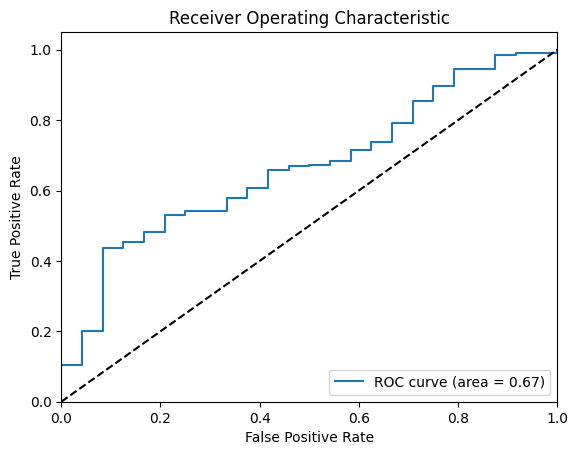

In [20]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Fit the logistic regression model, bump max_iter to 500 to avoid errors
model = LogisticRegression(solver="liblinear", max_iter=500).fit(X_train, Y_train)

# Predict the test data
Y_pred = model.predict(X_test)

# Calculate the probabilities for the positive class
Y_pred_prob = model.predict_proba(X_test)[:,1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)

# Calculate the area under the ROC curve
auc = roc_auc_score(Y_test, Y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Question 2.2: Apply RFE with a logistic regression model on the training data testing out different number of features. Predict the test data and plot the ROC curve.

In [22]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# NOTE: Before I added a scaler to the X_train and X_test, the model was not converging and 
# display errors stating that MAX iterations was reached and suggested that I add scaling according
# to the documentation here: https://scikit-learn.org/stable/modules/preprocessing.html
lr = LogisticRegression(max_iter=500)
X_train_scaled = StandardScaler().fit_transform(X_train)
rfe = RFE(lr, n_features_to_select=200, step=1).fit(X_train_scaled, Y_train)

X_test_scaled = StandardScaler().fit_transform(X_test)
# Predict the test data
Y_pred = model.predict(X_test_scaled)

C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Just want to visualize the before and after of the X_train data after scaling

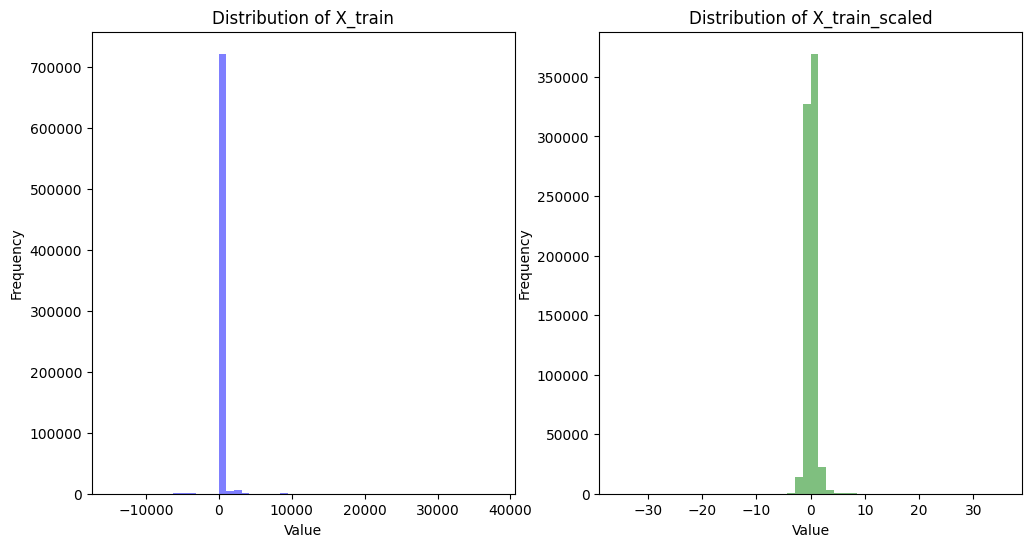

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot the distribution of X_train
axs[0].hist(X_train.values.flatten(), bins=50, color='blue', alpha=0.5)
axs[0].set_title('Distribution of X_train')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot the distribution of X_train_scaled
axs[1].hist(X_train_scaled.flatten(), bins=50, color='green', alpha=0.5)
axs[1].set_title('Distribution of X_train_scaled')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.show()



Plot the ROC curve

AUC: 0.6242816091954023


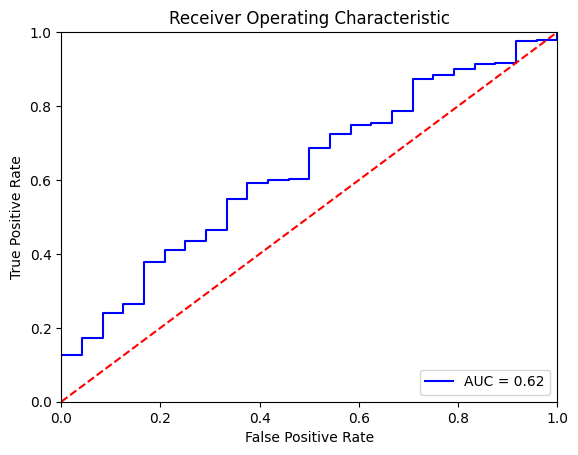

In [26]:
# Plot outputs
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

%matplotlib inline

# calculate the fpr and tpr for all thresholds of the classification
probs = rfe.predict_proba(X_test_scaled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("AUC: {}".format(roc_auc))

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Question 3.1: Apply stratified tain test split to account for class imbalance

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)

# Scale the data so we don't get errors below: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
# Increase the number of iterations (max_iter) or scale the data as shown in:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

Question 3.2: Apply RFE with a logistic regression model on the stratisfied training data testing out different number of features. Predict the test data and plot the ROC curve.

In [28]:
regr = RFE(LogisticRegression(max_iter=500), n_features_to_select=200, step=1)
regr.fit(X_train_scaled, Y_train)

RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=200)

AUC: 0.587843328457663


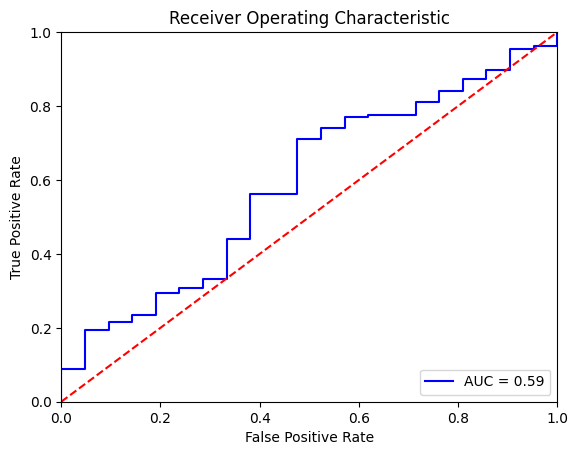

In [29]:
# calculate the fpr and tpr for all thresholds of the classification
probs = regr.predict_proba(X_test_scaled)
preds = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("AUC: {}".format(roc_auc))

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Question 4.1: Apply stratisfied K-Fold split where K=5 to the above data 

[0.589171974522293, 0.8662420382165605, 0.8785942492012779, 0.8626198083067093, 0.8817891373801917]


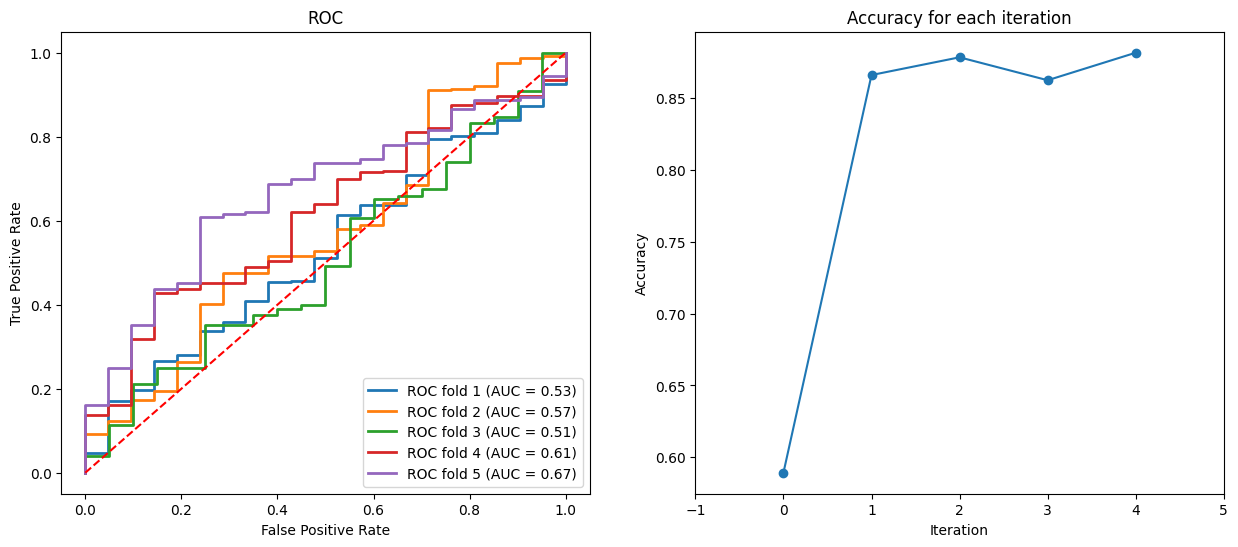

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5)
model = LogisticRegression(solver = 'lbfgs', max_iter=500)

# I'm starting with the original data sets since I don't think I need to do test/train splits
X = data.iloc[:, :-1]
# scale it to avoid errors because the data is not normalized
X_scaled = StandardScaler().fit_transform(X)
# Get the labels
Y = data.iloc[:, -1]

accuracy = []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

i=1
for train, test in skf.split(X_scaled, Y):
    probs = model.fit(X_scaled[train], Y[train]).predict_proba(X_scaled[test])
    preds = probs[:,1]
    accuracy.append(metrics.accuracy_score(Y[test], model.predict(X_scaled[test])))
    fpr, tpr, _ = metrics.roc_curve(Y[test], preds)
    roc_auc = metrics.auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

print(accuracy)

axes[0].legend(loc = 'lower right')
axes[0].set_title('ROC Curve for each iteration')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_title('ROC')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')

axes[1].plot(accuracy, marker='o')
axes[1].set_title('Accuracy for each iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlim([-1,5])
plt.show()


Implement the model and then create the ROC Curve

In [31]:
# Plot the ROC curve
# See above ^^^
# I tried doing this all together in the cell above.


Question 4.2: Summarize your findings of all above models

There were some dramatic improvements in AUC score when going from an RFE strategy of replacement to using k-fold.
We can see this in looking at AUC score for problem 3.2 which was AUC=0.59. The score increased in the final fold in problem
4.1 with an AUC=0.67. There was however a worse performance on some folds as well. So I am not sure how this can translate into a better model overall.

<h3> Question 5. Create a new text cell in your Notebook: Complete a 50-100 word summary 
    (or short description of your thinking in applying this week's learning to the solution) 
     of your experience in this assignment. Include:
<br>                                                                       
What was your incoming experience with this model, if any?
what steps you took, what obstacles you encountered.
how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?)
This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.
</h3>

Honestly, I believe I understand the mechanics of implementing Recursive Feature Elimination and k-fold splits when training my logistic regression models. The mechanics are fairly straightforward (though I did spend a lot of time trying to figure out how to calculate 5 different AUC/FPR/TPR values when doing the k-fold split). However what is not so clear to me is how does this make a better model for me? How can I use the best AUC scoring fold from the k-fold split training to improve my final model?

Also I am unsure how to interpret the fact that for my k-fold split, the accuracy score of the first fold was terrible relative to the rest. I can't tell if I made a mistake in the calculation or if this indicates that one of the folds had wildly un-representative data. It is interesting the for all the other folds, the accuracy was 85+% but for the first fold it was much lower at slightly under 59%.

Another error that I got on one of my Logistic regressions was the following:

```
UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
```

I couldn't find any satisfactory explanation of this error. I also didn't observe the error on other regressions for the same data.